# Pretrained Models for Computer Vision

The goal of this notebook is get some hands-on experience with pre-trained Keras models that are reasonably close to the state of the art of some computer vision tasks. The models are pre-trained on large publicly available labeled images datasets such as [ImageNet](http://www.image-net.org/) and [COCO](http://cocodataset.org/).

This notebook highlights two specific tasks:

- **Image classification**: predict only one class label per-image (assuming a single centered object or image class)

- **Object detection and instance segmentation**: detect and localise all occurences of objects of a predefined list of classes of interest in a given image.

In [140]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

## Loading a JPEG file as a numpy array

Let's use [scikit-image](http://scikit-image.rg) to load the content of a JPEG file into a numpy array:

In [141]:
from skimage.io import imread

image = imread('laptop.jpeg')
type(image)

numpy.ndarray

The dimensions of the array are:
- height
- width
- color channels (RGB)

In [142]:
image.shape

(450, 800, 3)

For efficiency reasons, the pixel intensities of each channel are stored as **8-bit unsigned integer** taking values in the **[0-255] range**:

In [143]:
image.dtype

dtype('uint8')

In [144]:
image.min(), image.max()

(0, 255)

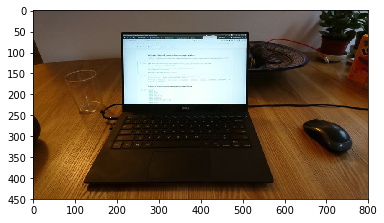

In [145]:
plt.imshow(image);

Indexing on the last dimension makes it possible to exactract the 2D content of a specific color channel, for instance the red channel:

In [146]:
red_channel = image[:, :, 0]
red_channel

array([[ 93,  92,  91, ..., 147,  86,  86],
       [ 94,  93,  91, ..., 154, 100,  69],
       [ 95,  93,  92, ..., 157, 109,  46],
       ..., 
       [128, 135, 133, ..., 118, 123, 124],
       [128, 135, 126, ..., 115, 122, 125],
       [127, 134, 125, ..., 114, 122, 125]], dtype=uint8)

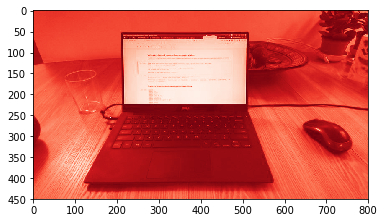

In [147]:
plt.imshow(image[:, :, 0], cmap=plt.cm.Reds_r);

In [169]:
grey_image = image.mean(axis=2) # axis=2 is the third axis
grey_image

array([[  79.        ,   78.33333333,   77.33333333, ...,  142.66666667,
          77.33333333,   74.66666667],
       [  80.        ,   79.33333333,   77.33333333, ...,  151.66666667,
          93.33333333,   59.66666667],
       [  81.        ,   79.33333333,   78.33333333, ...,  158.66666667,
         105.33333333,   39.33333333],
       ..., 
       [  74.        ,   81.        ,   79.        , ...,   84.        ,
          89.        ,   90.        ],
       [  75.        ,   82.        ,   73.        , ...,   79.        ,
          86.        ,   87.66666667],
       [  74.        ,   81.        ,   72.        , ...,   78.        ,
          86.        ,   87.66666667]])

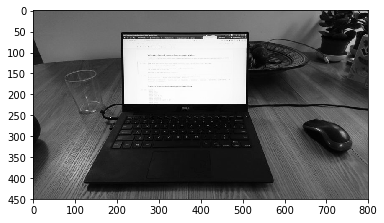

In [149]:
plt.imshow(grey_image, cmap=plt.cm.Greys_r);

## Resizing images, handling data types and dynamic ranges

When dealing with an hetereogeneous collection of image of various sizes, it is often necessary to resize the image to the same size. More specifically:

- for **image classification**, most networks expect a specific **fixed input size**;

- for **object detection** and instance segmentation, networks have more flexibility but the image should have **approximately the same size as the training set images**.

Furthermore **large images can be much slower to process** than smaller images (the number of pixels varies quadratically with the height and width).

In [165]:
from skimage.transform import resize


lowres_image = resize(image, (50, 50), mode='reflect')
lowres_image.shape

(50, 50, 3)

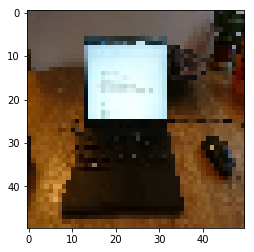

In [168]:
plt.imshow(lowres_image);

The values of the pixels of the low resolution image are computed from by combining the values of the pixels in the high resolution image. The result is therefore represented as floating points. 

In [166]:
lowres_image.dtype

dtype('float64')

By conventions, both `skimage.transform.imresize` and `plt.imshow` assume that floating point values range from 0.0 to 1.0 when using floating points as opposed to 0 to 255 when using 8-bit integers:

In [375]:
lowres_image.min(), lowres_image.max()

(0.0, 1.0)

Note that keras on the other hands might expect images encoded with values in the `[0.0 - 255.0]` range irrespectively of the data type of the array. To avoid

In [379]:
lowres_large_range_image = resize(image, (50, 50), mode='reflect', preserve_range=True)
lowres_large_range_image.shape, lowres_large_range_image.dtype

((50, 50, 3), dtype('float64'))

In [380]:
lowres_large_range_image.min(), lowres_large_range_image.max()

(0.0, 255.0)

##  Taking snapshots from the webcam

Let's use the [python API of OpenCV](pypi.python.org/pypi/opencv-python) to take pictures.

In [271]:
import cv2

def camera_grab(camera_id=0, fallback_filename=None):
    camera = cv2.VideoCapture(camera_id)
    try:
        # take 10 consecutive snapshots to let the camera automatically tune
        # itself and hope that the contrast and lightning of the last snapshot
        # is good enough.
        for i in range(10):
            snapshot_ok, image = camera.read()
        if snapshot_ok:
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        else:
            print("WARNING: could not access camera")
            if fallback_filename:
                image = imread(fallback_filename)
    finally:
        camera.release()
    return image

dtype: uint8, shape: (480, 640, 3), range: (31, 255)


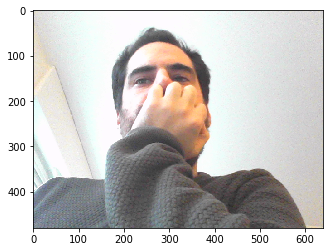

In [272]:
image = camera_grab(camera_id=0, fallback_filename='laptop.jpeg')
plt.imshow(image)
print("dtype: {}, shape: {}, range: {}".format(
    image.dtype, image.shape, (image.min(), image.max())))

## Image Classification


The Keras library includes

In [66]:
from keras.applications.mobilenet import preprocess_input, MobileNet

mobilenet = MobileNet(weights='imagenet')

Let's check that tensorflow backend used by Keras as the default backend expect the color channel on the last axis. If it had not been the case, it would have been possible to change the order of the axes with `images = images.transpose(2, 0, 1)`.

In [244]:
import keras.backend as K

K.image_data_format()

'channels_last'

In [338]:
image = imread('laptop.jpeg')
image_224 = resize(image, (224, 224), preserve_range=True, mode='reflect')

In [339]:
image_224.dtype

dtype('float64')

In [340]:
image_224 = image_224.astype(np.float32)
image_224.dtype

dtype('float32')

In [341]:
image_224.shape

(224, 224, 3)

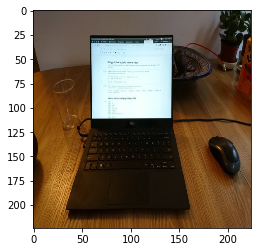

In [342]:
plt.imshow(image_224 / 255);

Note that the image has been deformed by the resizing. In practice this should not degrade the performance of the network too much.

In [381]:
image_224_batch = np.expand_dims(image_224, axis=0)
image_224_batch.shape

(1, 224, 224, 3)

In [344]:
%%time
preds = mobilenet.predict(preprocess_input(image_224_batch))

CPU times: user 516 ms, sys: 8 ms, total: 524 ms
Wall time: 213 ms


The output predictions are a 2D array:

- 1 row per image in the batch,
- 1 column per target class in the ImageNet LSVRC dataset (1000 possible classes).

In [345]:
type(preds)

numpy.ndarray

In [346]:
preds.dtype

dtype('float32')

In [347]:
preds.shape

(1, 1000)

In [348]:
preds.sum(axis=1)

array([ 1.00000024], dtype=float32)

### Decoding the Prediction Probabilities

In [237]:
from keras.applications.mobilenet import decode_predictions

print('Predicted image labels:')
class_names, confidences = [], []
for class_id, class_name, confidence in decode_predictions(preds, top=5)[0]:
    print("{} (synset: {}): {:0.3f}".format(class_name, class_id, confidence))

Predicted image labels:
cellular_telephone (synset: n02992529): 0.111
lighter (synset: n03666591): 0.088
sunglasses (synset: n04356056): 0.081
iPod (synset: n03584254): 0.078
barbershop (synset: n02791270): 0.076


In [200]:
decode_predictions(preds, top=5)

[[('n03729826', 'matchstick', 0.053736839),
  ('n04286575', 'spotlight', 0.050874643),
  ('n01930112', 'nematode', 0.046085797),
  ('n03196217', 'digital_clock', 0.045754395),
  ('n04418357', 'theater_curtain', 0.027026212)]]

### Exercise

- Write a function named `classify` that takes a snapshot of the webcam and displays it along with the decoded predictions of mobilenet and their confidence level.

- If you don't have access to a webcam take a picture with your mobile phone or a photo of your choice from the web, store it as a JPEG file on the disk instead and use that file to make the prediction instead.

- Try to classify a photo of your face. Can you explain the results?

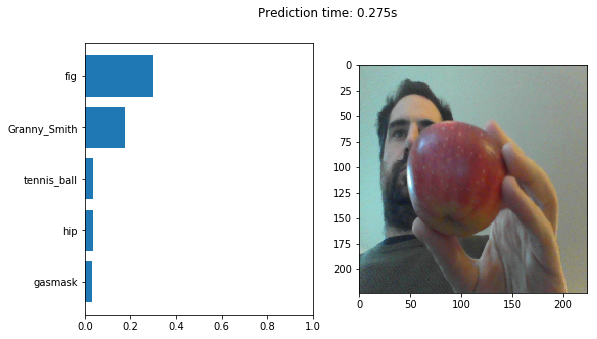

In [358]:
def classifiy():
    # TODO: write me
    pass

    
classify()

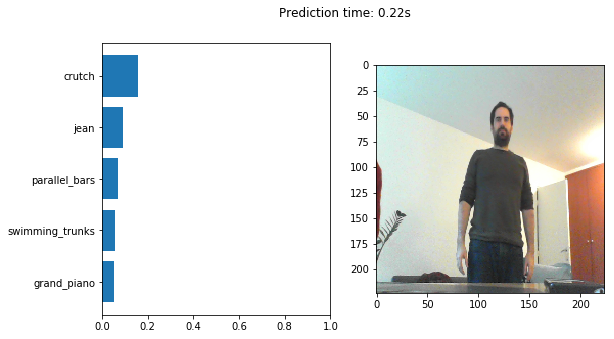

In [374]:
import time

def classify():
    image = camera_grab(camera_id=0, fallback_filename='laptop.jpeg')

    image = resize(image, (224, 224), preserve_range=True, mode='reflect')
    image_batch = preprocess_input(np.expand_dims(image.astype(np.float32), axis=0))

    tic = time.time()
    results = decode_predictions(mobilenet.predict(image_batch))[0]
    toc = time.time()

    fig, (ax0, ax1) = plt.subplots(nrows=1, ncols=2, figsize=(9, 5))
    classnames = [r[1] for r in reversed(results)]
    confidences = [r[2] for r in reversed(results)]
    pos = np.arange(len(classnames))

    ax0.barh(pos, confidences)
    ax0.set_yticks(pos)
    ax0.set_yticklabels(classnames)
    ax0.set_xlim(0, 1)
    ax1.imshow(image / 255)
    fig.suptitle("Prediction time: {:0.3}s".format(toc - tic))


classify()

In [372]:
image.dtype, image.max()

(dtype('uint8'), 255)

Check on imagenet to better understand the use of the term "notebook" in the training set: http://image-net.org/search?q=notebook.

In [255]:
plt.barh?

### Home assignement #1

Use the "Resnet 50" and "Inception Resnet v2" models from `keras.applications` instead of MobileNet to classify images from the webcam or stored as a JPEG file.

Read the documentation for more details on the expected input shape and preprocessing:

https://keras.io/applications/

Measure prediction time using `%%time` to compare to MobileNet.

In [182]:
%%time

a = 0
for i in range(10000000):
    a += 1
print('Computation complete!')

Computation complete!
CPU times: user 924 ms, sys: 0 ns, total: 924 ms
Wall time: 927 ms


In [183]:
## TODO: implement solution

### Home assignment #2

Classify a many images at once.

In [ ]:
import os



## Instance Detection and Segmentation with Mask-RCNN


[Mask RCNN](https://arxiv.org/abs/1703.06870) is a refinement of the [Faster RCNN](https://arxiv.org/abs/1506.01497) **object detection** model to also add support for **instance segmentation**.

The following shows how to use a [Keras based implementation](https://github.com/matterport/Mask_RCNN) provided by matterport.com along with model parameters pretrained on the [COCO object detection dataset](http://cocodataset.org/).

In [68]:
import os
import sys
import random
import math
import numpy as np
import skimage.io
import matplotlib
import matplotlib.pyplot as plt

import config
import utils
import model as modellib
import visualize

%matplotlib inline 

# Root directory of the project
ROOT_DIR = os.getcwd()

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")
# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

# Directory of images to run detection on
IMAGE_DIR = os.path.join(ROOT_DIR, "images")

## Configurations

We'll be using a model trained on the MS-COCO dataset. The configurations of this model are in the ```CocoConfig``` class in ```coco.py```.

For inferencing, modify the configurations a bit to fit the task. To do so, sub-class the ```CocoConfig``` class and override the attributes you need to change.

In [69]:
class InferenceCocoConfig(config.Config):
    # Give the configuration a recognizable name
    NAME = "inference_coco"

    # Number of classes (including background)
    NUM_CLASSES = 1 + 80  # COCO has 80 classes

    # Set batch size to 1 since we'll be running inference on
    # one image at a time. Batch size = GPU_COUNT * IMAGES_PER_GPU
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

config = InferenceConfig()
config.display()


Configurations:
BACKBONE_SHAPES                [[256 256]
 [128 128]
 [ 64  64]
 [ 32  32]
 [ 16  16]]
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [ 0.1  0.1  0.2  0.2]
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
GPU_COUNT                      1
IMAGES_PER_GPU                 1
IMAGE_MAX_DIM                  1024
IMAGE_MIN_DIM                  800
IMAGE_PADDING                  True
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
MASK_POOL_SIZE                 14
MASK_SHAPE                     [28, 28]
MAX_GT_INSTANCES               100
MEAN_PIXEL                     [ 123.7  116.8  103.9]
MINI_MASK_SHAPE                (56, 56)
NAME                           coco
NUM_CLASSES                    81
POOL_SIZE                      7
POST_NMS_ROIS_INFERENCE        1000
POST_NMS_ROIS_TRAINI

## Create Model and Load Trained Weights

In [70]:
# Create model object in inference mode.
model = modellib.MaskRCNN(mode="inference", model_dir=MODEL_DIR, config=config)

# Load weights trained on MS-COCO
model.load_weights(COCO_MODEL_PATH, by_name=True)

## Class Names

The model classifies objects and returns class IDs, which are integer value that identify each class. Some datasets assign integer values to their classes and some don't. For example, in the MS-COCO dataset, the 'person' class is 1 and 'teddy bear' is 88. The IDs are often sequential, but not always. The COCO dataset, for example, has classes associated with class IDs 70 and 72, but not 71.

To improve consistency, and to support training on data from multiple sources at the same time, our ```Dataset``` class assigns it's own sequential integer IDs to each class. For example, if you load the COCO dataset using our ```Dataset``` class, the 'person' class would get class ID = 1 (just like COCO) and the 'teddy bear' class is 78 (different from COCO). Keep that in mind when mapping class IDs to class names.

To get the list of class names, you'd load the dataset and then use the ```class_names``` property like this.
```
# Load COCO dataset
dataset = coco.CocoDataset()
dataset.load_coco(COCO_DIR, "train")
dataset.prepare()

# Print class names
print(dataset.class_names)
```

We don't want to require you to download the COCO dataset just to run this demo, so we're including the list of class names below. The index of the class name in the list represent its ID (first class is 0, second is 1, third is 2, ...etc.)

In [71]:
# COCO Class names
# Index of the class in the list is its ID. For example, to get ID of
# the teddy bear class, use: class_names.index('teddy bear')
class_names = ['BG', 'person', 'bicycle', 'car', 'motorcycle', 'airplane',
               'bus', 'train', 'truck', 'boat', 'traffic light',
               'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird',
               'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear',
               'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie',
               'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
               'kite', 'baseball bat', 'baseball glove', 'skateboard',
               'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup',
               'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple',
               'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
               'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed',
               'dining table', 'toilet', 'tv', 'laptop', 'mouse', 'remote',
               'keyboard', 'cell phone', 'microwave', 'oven', 'toaster',
               'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors',
               'teddy bear', 'hair drier', 'toothbrush']

## Run Object Detection

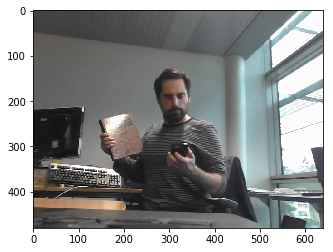

In [129]:
import time
time.sleep(3)
image = camera_grab()
if image is not None:
    plt.imshow(image);

In [133]:
skimage.io.imsave(os.path.expanduser('~/Pictures/webcam_shot.jpeg'), image)

In [136]:
image = skimage.io.imread('/home/ogrisel/Pictures/webcam_shot.jpeg')

In [137]:
image.shape

(480, 640, 3)

Processing 1 images
image                    shape: (480, 640, 3)         min:    0.00000  max:  255.00000
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000
image_metas              shape: (1, 89)               min:    0.00000  max: 1024.00000
Analyzed image in 23.414s
person:	1.000
keyboard:	0.997
cell phone:	0.954
book:	0.943
dining table:	0.916
chair:	0.845
chair:	0.837
tv:	0.785


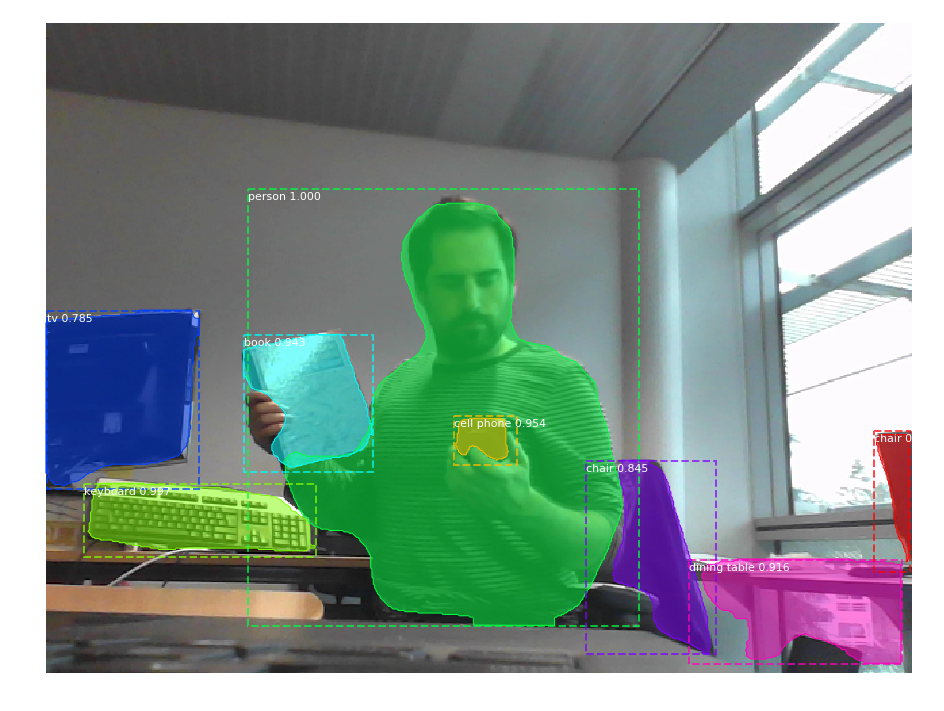

In [130]:
# Run detection
tic = time.time()
results = model.detect([image], verbose=1)
toc = time.time()
print("Analyzed image in {:.3f}s".format(toc - tic))

# Visualize results
r = results[0]
for class_id, score in zip(r['class_ids'], r['scores']):
    print("{}:\t{:0.3f}".format(class_names[class_id], score))
visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], 
                            class_names, r['scores'])

Processing 1 images
image                    shape: (465, 800, 3)         min:    0.00000  max:  255.00000
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  129.30000
image_metas              shape: (1, 89)               min:    0.00000  max: 1024.00000


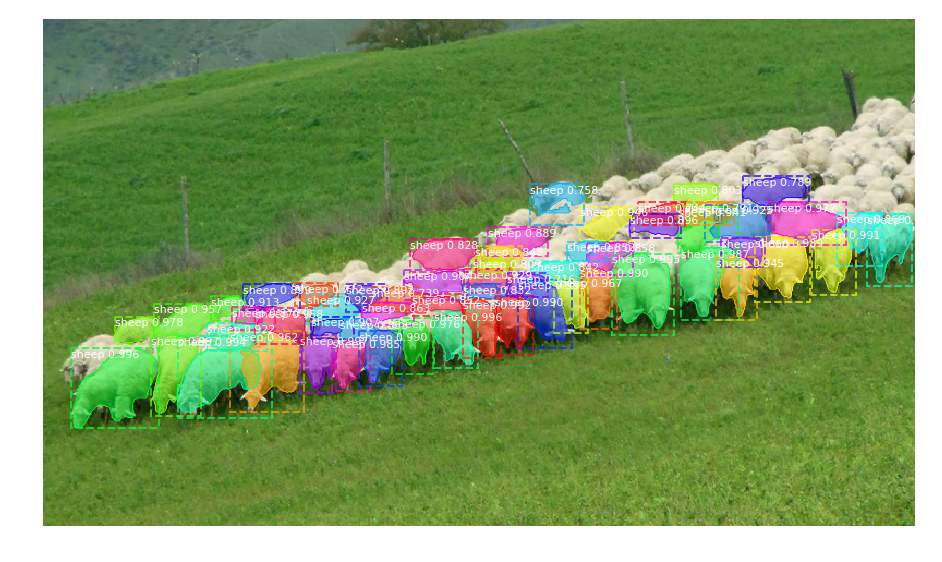

In [74]:
# Load a random image from the images folder
file_names = next(os.walk(IMAGE_DIR))[2]
image = skimage.io.imread(os.path.join(IMAGE_DIR, random.choice(file_names)))
image = skimage.io.imread(os.path.expanduser('/home/ogrisel/Pictures/HerdOfSheep.jpg'))

# Run detection
results = model.detect([image], verbose=1)

# Visualize results
r = results[0]
visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], 
                            class_names, r['scores'])